In [1]:
import gc
import re
import pickle

import dill
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification, AutoModel, GPT2Tokenizer
from torch.optim.lr_scheduler import ExponentialLR

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

torch.cuda.empty_cache()
gc.collect()

# from dataset import TextDataset, clean

840

In [2]:
df_og = pd.read_parquet("cspref/data/train-00000-of-00001.parquet")

# little bit of cleaning
for col in ['sent_1', 'sent_2']:
    df_og[col] = df_og[col].apply(lambda x:  x.split('\n')[0] if '\n' in x else x)

df = df_og.sample(n=int(df_og.shape[0] * 0.6), random_state=42)

chosen_class = {
    "sent_1": 0,
    "sent_2": 1,
    "tie": 2
}

df["chosen"] = df["chosen"].apply(lambda x: chosen_class[x])

class TextDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer
        self.tokenized_data = []
        self.label_dict = {
            0: torch.tensor([1, 0, 0]),
            1: torch.tensor([0, 1, 0]),
            2: torch.tensor([0, 0, 1])
        }

        kwargs = {
            # "add_special_tokens": True,
            "padding": "max_length",
            "truncation": True,
            "return_attention_mask": True,
            "return_tensors": "pt"
        }

        for idx in range(len(df)):
            prepend = (
                df.iloc[idx]["original_l1"]
                + "+"
                + df.iloc[idx]["original_l2"]
                + "->"
            )
            text1 = prepend + df.iloc[idx]["sent_1"]
            text2 = prepend + df.iloc[idx]["sent_2"]
            text1_enc = self.tokenizer.encode_plus(text1, **kwargs)
            text2_enc = self.tokenizer.encode_plus(text2, **kwargs)

            chosen = df.iloc[idx]["chosen"]
            label = self.label_dict[chosen]

            self.tokenized_data.append((text1_enc, text2_enc, chosen, label))

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, item):
        return self.tokenized_data[item]

### Train

In [3]:
MODEL = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
tokenizer.pad_token = tokenizer.eos_token

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
batch_size = 8
train_dataset = TextDataset(train_df, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [4]:
class DecisionModel(nn.Module):
    def __init__(self):
        super(DecisionModel, self).__init__()
        self.fc1 = nn.Linear(768, 64)
        self.fc2 = nn.Linear(64, 1)
        self.reward_to_class = nn.Linear(2, 3)

    def forward(self, x1, x2):
        r1 = self.fc2(F.gelu(self.fc1(x1)))
        r2 = self.fc2(F.gelu(self.fc1(x2)))
        
        out = F.relu(torch.concat((r1, r2), dim=1))
        out = self.reward_to_class(out)
        out = F.log_softmax(out, dim=1)

        return out


class RewardModel(nn.Module):
    def __init__(self, enc_model, decision, device):
        super(RewardModel, self).__init__()
        self.enc_model = enc_model
        self.decision = decision
        self.device = device

    def forward(self, x):
        # x: [x1, x2, label]
        input_ids = x[0]['input_ids'].squeeze(dim=1).to(self.device)
        attention_mask = x[0]['attention_mask'].squeeze(dim=1).to(self.device)
        out1 = self.enc_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        out1 = out1.hidden_states[-1][:, -1, :]

        input_ids = x[1]['input_ids'].squeeze(dim=1).to(self.device)
        attention_mask = x[1]['attention_mask'].squeeze(dim=1).to(self.device)
        out2 = self.enc_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        out2 = out2.hidden_states[-1][:, -1, :]

        output = self.decision(out1, out2)
        label = x[-1].to(self.device)

        return output, label

In [5]:
MODEL = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
tokenizer.pad_token = tokenizer.eos_token

enc_model = AutoModel.from_pretrained("gpt2")

dm = DecisionModel()
rm = RewardModel(enc_model, dm, device)
rm.to(device)

print("Not anymore")

Not anymore


In [6]:
optimizer = torch.optim.AdamW([
    {"params": rm.decision.parameters(), "lr": 3e-5},
    {"params": rm.enc_model.parameters(), "lr": 3e-5},
], lr=3e-5)

scheduler = ExponentialLR(optimizer, gamma=0.9)

In [7]:
# checkpoint_path = "ckpts_nl/checkpoint_gpt2_60_3.pth"
# checkpoint = torch.load(checkpoint_path)

# rm.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
# print(scheduler.get_lr())

In [ ]:
completed_num_epochs = 6

checkpoint_path = f"ckpts_nl/checkpoint_gpt2_60_{completed_num_epochs - 1}.pth"
checkpoint = torch.load(checkpoint_path)

rm.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])


epochs = 8 - completed_num_epochs


accumulation_steps = 3

for epoch in range(epochs):
    rm.train()
    total_loss = 0

    for batch_id, batch in enumerate(train_dataloader):
        out, label = rm(batch)
        loss = - (out * label).sum() / label.shape[0]
        loss.backward()

        if (batch_id + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item()

        if batch_id % 100 == 0:
            print(loss.item())

    # If the number of batches isn't divisible by accumulation_steps,
    # do one final step after the loop ends
    if (batch_id + 1) % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    scheduler.step()

    avg_loss = total_loss / len(train_dataloader)

    print(f"Epoch {epoch + completed_num_epochs}")
    print(f"Average Training Loss: {avg_loss:.4f}")
    print("\n")

    checkpoint = {
        'model_state_dict': rm.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'epoch': epoch + completed_num_epochs,
        'avg_loss': avg_loss
    }

    torch.save(checkpoint, f"ckpts_nl/checkpoint_gpt2_60_{epoch + completed_num_epochs}.pth")

0.8508423566818237
0.9418230652809143
0.9931835532188416
0.785681962966919
0.9073892831802368
0.9551669955253601
0.7368096113204956
1.0029284954071045
0.6765177249908447


In [1]:
# torch.save(rm.state_dict(), "gpt2_rm_dict_2.pth")

### Test

In [11]:
# "gpt2_rm_3_dict.pth": 30%, epoch: 3
# "gpt2_rm_dict.pth": 20%, epoch: 5

rm.load_state_dict(torch.load("models_w_tie/gpt2_rm_w_tie_40_3.pth"))

<All keys matched successfully>

In [8]:
MODEL = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
tokenizer.pad_token = tokenizer.eos_token


test_dataset = TextDataset(test_df, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

test_dataloader.dataset.df.shape

(5009, 7)

In [12]:
rm.load_state_dict(torch.load("models_w_tie/gpt2_rm_w_tie_40_3.pth"))

rm.eval()

all_preds = []
true_labels = []  # with randomized ties
chosen = []
pred_model_probs = []

for batch_id, batch in enumerate(test_dataloader):
    chosen += batch[2].tolist()
    out, label = rm(batch)
    probs = F.softmax(out, dim=1)
    pred_model_probs += probs.to("cpu").tolist()
    all_preds += probs.argmax(dim=1)
    true_labels += label.argmax(dim=1).to("cpu").tolist()

In [13]:
(torch.tensor(all_preds) == torch.tensor(true_labels)).sum() / len(all_preds)

tensor(0.5983)

In [14]:
rm.load_state_dict(torch.load("models_w_tie/gpt2_rm_w_tie_40_2.pth"))

rm.eval()

all_preds = []
true_labels = []  # with randomized ties
chosen = []
pred_model_probs = []

for batch_id, batch in enumerate(test_dataloader):
    chosen += batch[2].tolist()
    out, label = rm(batch)
    probs = F.softmax(out, dim=1)
    pred_model_probs += probs.to("cpu").tolist()
    all_preds += probs.argmax(dim=1)
    true_labels += label.argmax(dim=1).to("cpu").tolist()
    
(torch.tensor(all_preds) == torch.tensor(true_labels)).sum() / len(all_preds)

tensor(0.5670)

In [47]:
(torch.tensor(all_preds) == torch.tensor(true_labels)).sum() / len(all_preds)

tensor(0.7519)

In [1]:
# acuracy of non-tie
non_tie_preds = [(i, j, k) for (i, j, k) in zip(all_preds, true_labels, chosen) if k != 2]
len([1 for (i, j, _) in non_tie_preds if i == j]) / len(non_tie_preds)

NameError: name 'all_preds' is not defined

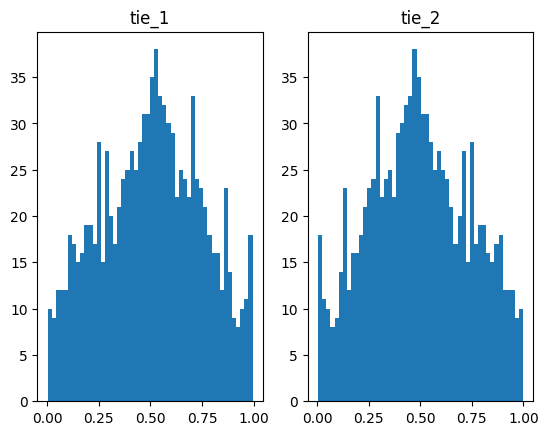

In [72]:
tie_1 = [p[0] for p, c in zip(pred_model_probs, chosen) if c == 2]
tie_2 = [p[1] for p, c in zip(pred_model_probs, chosen) if c == 2]

fig, axs = plt.subplots(1, 2)

axs[0].hist(tie_1, bins=50)
axs[0].set_title("tie_1")

axs[1].hist(tie_2, bins=50)
axs[1].set_title("tie_2")

# plt.tight_layout()
plt.show()

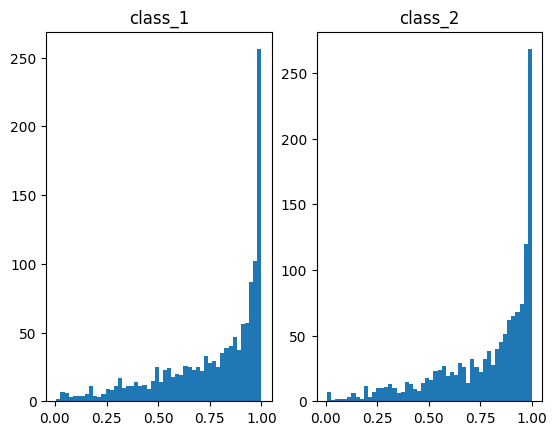

In [73]:
class_1 = [p[0] for p, c in zip(pred_model_probs, chosen) if c == 0]
class_2 = [p[1] for p, c in zip(pred_model_probs, chosen) if c == 1]

fig, axs = plt.subplots(1, 2)

axs[0].hist(class_1, bins=50)
axs[0].set_title("class_1")

axs[1].hist(class_2, bins=50)
axs[1].set_title("class_2")

# plt.tight_layout()
plt.show()

In [94]:
pd.merge(
    train_df,
    test_df,
    on=["original_l1", "original_l2", "sent_1", "sent_2", "chosen"]
).shape

(20, 9)

In [28]:
F.softmax(out, dim=1).argmax(dim=1).to("cpu").tolist()

[1, 0, 1, 0]

In [96]:
out

tensor([[-0.7306, -0.6571]], device='cuda:1', grad_fn=<LogSoftmaxBackward0>)

In [23]:
label

tensor([[1, 0],
        [0, 1],
        [1, 0],
        [0, 1]], device='cuda:1')

In [15]:
for b in train_dataloader:
    break
tout = rm(b)

RuntimeError: stack expects each tensor to be equal size, but got [1, 140] at entry 0 and [1, 165] at entry 1

In [7]:
tout

(tensor([[-0.7010, -0.6854],
         [-0.6841, -0.7022],
         [-0.6704, -0.7164],
         [-0.6816, -0.7048],
         [-0.6888, -0.6975],
         [-0.8291, -0.5735],
         [-0.6787, -0.7078],
         [-0.6922, -0.6941]], device='cuda:1', grad_fn=<LogSoftmaxBackward0>),
 tensor([[0, 1],
         [1, 0],
         [1, 0],
         [0, 1],
         [1, 0],
         [0, 1],
         [1, 0],
         [1, 0]], device='cuda:1'))

In [10]:
(tout[0] * tout[1]).sum() / tout[1].shape[0]
(out * label).sum() / label.shape[0]


tensor(-0.6722, device='cuda:1', grad_fn=<DivBackward0>)

In [11]:
tout[1].shape[0]

torch.Size([8, 2])

### check

In [5]:
enc_model = AutoModel.from_pretrained("gpt2")
enc_model.to(device)

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [15]:
prompt = "the meaning of life "
inp = tokenizer(prompt, return_tensors="pt")

out = enc_model(input_ids=inp["input_ids"].to(device), attention_mask=inp["attention_mask"].to(device), output_hidden_states=True)

In [16]:
out.hidden_states[-1].shape

torch.Size([1, 5, 768])

In [19]:
out1, out2 = out.hidden_states[-1][:, -1, :], out.hidden_states[-1][:, 0, :]

out1.shape, out2.shape,

(torch.Size([1, 768]), torch.Size([1, 768]))

In [20]:
# F.softmax(
r1 = nn.Linear(64, 1).to(device)(
F.gelu(
    nn.Linear(768, 64).to(device)(
        torch.concat([out2, out1, out2, out2], dim=0)
    )
)
)
r2 = nn.Linear(64, 1).to(device)(
F.gelu(
    nn.Linear(768, 64).to(device)(
        torch.concat([out1, out2, out2, out2], dim=0)
    )
)
)
# , dim=0)

In [21]:
r1, r2

(tensor([[-0.0151],
         [ 0.1738],
         [-0.0151],
         [-0.0151]], device='cuda:3', grad_fn=<AddmmBackward0>),
 tensor([[0.0393],
         [0.0578],
         [0.0578],
         [0.0578]], device='cuda:3', grad_fn=<AddmmBackward0>))

In [23]:
F.relu(torch.concat((r1, r2), dim=1))

tensor([[0.0000, 0.0393],
        [0.1738, 0.0578],
        [0.0000, 0.0578],
        [0.0000, 0.0578]], device='cuda:3', grad_fn=<ReluBackward0>)

In [22]:
cl = nn.Linear(2, 3).to(device)(
    torch.concat((r1, r2), dim=1)
)

cl

tensor([[ 0.5560,  0.7763,  0.2602],
        [ 0.3082,  0.3112,  0.1111],
        [ 0.1885,  0.2698, -0.0855],
        [ 0.1885,  0.2698, -0.0855]], device='cuda:1',
       grad_fn=<AddmmBackward0>)

In [24]:
F.softmax(cl, dim=1)

tensor([[0.3344, 0.4168, 0.2488],
        [0.3541, 0.3552, 0.2908],
        [0.3515, 0.3813, 0.2672],
        [0.3515, 0.3813, 0.2672]], device='cuda:1', grad_fn=<SoftmaxBackward0>)

In [ ]:
class DecisionModel(nn.Module):
    def __init__(self):
        super(DecisionModel, self).__init__()
        self.fc1 = nn.Linear(768, 64)
        self.fc2 = nn.Linear(64, 1)
        self.reward_to_class = nn.Linear(2, 3)

    def forward(self, x1, x2):
        r1 = self.fc2(F.gelu(self.fc1(x1)))
        r2 = self.fc2(F.gelu(self.fc1(x2)))

        out = self.reward_to_class(
            torch.concat((r1, r2), dim=1)
        )

        out = F.log_softmax(out, dim=1)
        return out


In [55]:
F.softmax(torch.concat((r1, r2), dim=1), dim=1)

tensor([[0.8041, 0.1959],
        [0.8815, 0.1185],
        [0.7102, 0.2898],
        [0.7102, 0.2898]], device='cuda:1', grad_fn=<SoftmaxBackward0>)

In [22]:
prompt = "hi there"
inp = tokenizer(prompt, return_tensors="pt")
out = enc_model.to(device)(input_ids=inp["input_ids"].to(device), attention_mask=inp["attention_mask"].to(device), output_hidden_states=True)

In [101]:
out.logits.shape
out.logits[:, -1, :].sort(descending=True).indices[0]

tensor([   11,   269,   264,  ..., 46136, 35061, 45384])

In [165]:
for i,j in enumerate(out.logits[:, -1, :].sort(descending=True).indices[0]):
    print(tokenizer.convert_ids_to_tokens(j.item()))
    # print(i, j)
    if i == 5:
        break

Ġis
.
,
Ġwas
's
Ġare


In [160]:
[k[1][0][0].shape for k in out.items()]

# out.items()["out.items()"]

[torch.Size([50257]), torch.Size([1, 12, 25, 64])]

In [126]:
import torch
import torch.nn.functional as F

prompt = "the meaning of life "
inp = tokenizer(prompt, return_tensors="pt")

out = model(input_ids=inp["input_ids"], attention_mask=inp["attention_mask"])

num_tokens_to_generate = 20
logits = out.logits
generated_token_ids = inp["input_ids"].squeeze().tolist()

for _ in range(num_tokens_to_generate):
    print(_)
    last_token_logits = logits[:, -1, :]
    probs = F.softmax(last_token_logits, dim=-1)
    next_token_id = torch.argmax(probs, dim=-1).item()

    generated_token_ids.append(next_token_id)

    inp["input_ids"] = torch.tensor([generated_token_ids]).to(inp["input_ids"].device)
    inp["attention_mask"] = torch.tensor(inp["attention_mask"].flatten().tolist() + [1]).view(1, -1)
    out = model(input_ids=inp["input_ids"], attention_mask=inp["attention_mask"])
    logits = out.logits

generated_text = tokenizer.decode(generated_token_ids, skip_special_tokens=True)
print(generated_text)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
the meaning of life  is not to be understood as a "life" but as a "life of the soul"


In [127]:
generated_text = tokenizer.decode(generated_token_ids, skip_special_tokens=True)
print(generated_text)


the meaning of life  is not to be understood as a "life" but as a "life of the soul"


In [79]:
tokenizer.convert_tokens_to_ids("up")

929

In [ ]:
optimizer = torch.optim.AdamW([
    {"params": rm.decision.parameters(), "lr": 5e-4},
    {"params": rm.enc_model.parameters(), "lr": 5e-5},
], lr=5e-5)

scheduler = ExponentialLR(optimizer, gamma=0.9)


epochs = 3
lr_history = []

for epoch in range(epochs):
    rm.train()
    total_loss = 0

    for batch_id, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        out, label = rm(batch)
        loss = - (out * label).sum() / label.shape[0]
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_id % 50 == 0:
            print(loss.item())

    scheduler.step()

    avg_loss = total_loss / len(train_dataloader)

    print(f"Epoch {epoch+1}")
    print(f"Average Training Loss: {avg_loss:.4f}")
    print("\n")